In [ ]:
import os
import cv2
import math
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from typing import List, Optional, Callable, Dict, Any
import time

import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
import time
from contextlib import nullcontext
from tqdm import tqdm
import wandb  # Asegúrate de tener wandb instalado


In [ ]:

def set_seed(seed_value: int = 42) -> None:
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed_value (int): The random seed value to be used.

    Returns:
        None
    """

    # Setting the random seed for numpy's random number generator
    np.random.seed(seed_value)

    # Setting the random seed for PyTorch's random number generator and the CUDA random number generator
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Setting the random seed for Python's built-in random library
    random.seed(seed_value)


class BabyFacesDataset(Dataset):
    """
    PyTorch Dataset class for loading baby face images and their associated oriented bounding box (OBB) annotations.

    Each image may have one or more annotations stored in a corresponding .txt label file.
    Label format per line:
        class_idx x1 y1 x2 y2 x3 y3 x4 y4 angle

    - class_idx: integer from 0 to 4 indicating face orientation
        (0 = 3/4 leftside, 1 = 3/4 rightside, 2 = frontal, 3 = left profile, 4 = right profile)
    - x1, y1, ..., x4, y4: normalized (0–1) coordinates of the OBB corners
    - angle: rotation angle in radians (clockwise), usually measured from the top-left corner

    Images without a corresponding label file are treated as background and assigned class index 5.

    It is assumed the dataset is organized as:
        root_dir/
            train/
                images/
                labels/
            val/
                images/
                labels/
            ...

    Args:
        root_dir (str): Path to the root directory of the dataset.
        split (str): Subdirectory name indicating the split ("train", "val", "test", etc.).
        file_list (Optional[List[str]]): List of image base names (without extension) to load. If None, all .jpg files in the image directory will be used.
        transform (Optional[Callable]): A function or transform to apply to each sample.
    """
    
    def __init__(
        self,
        root_dir: str,
        split: str = "train",
        file_list: Optional[List[str]] = None,
        transform: Optional[Callable] = None
    ):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.images_dir = os.path.join(root_dir, split, "images")
        self.labels_dir = os.path.join(root_dir, split, "labels")

        if file_list is None:
            self.file_list = [
                os.path.splitext(f)[0]
                for f in os.listdir(self.images_dir)
                if f.lower().endswith(".jpg")
            ]
        else:
            self.file_list = file_list

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        base_name = self.file_list[idx]
        img_path = os.path.join(self.images_dir, base_name + ".jpg")
        label_path = os.path.join(self.labels_dir, base_name + ".txt")

        # Load image in RGB format
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image file: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        boxes = []       # List of flattened (x1, y1, ..., x4, y4) in pixel coordinates
        angles = []      # Rotation angles in radians
        class_idxs = []  # Class indices

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 10:
                        continue  # skip malformed lines

                    class_idx = int(parts[0])
                    coords = list(map(float, parts[1:9]))
                    angle = float(parts[9])

                    coords_px = []
                    for i in range(0, 8, 2):
                        x = coords[i] * width
                        y = coords[i + 1] * height
                        coords_px.extend([x, y])

                    class_idxs.append(class_idx)
                    boxes.append(coords_px)
                    angles.append(angle)
        else:
            # Background image — no boxes or angles, just class index 5
            class_idxs.append(5)

        # Build target dictionary
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),        # shape (N, 8) or (0, 8)
            "angles": torch.tensor(angles, dtype=torch.float32),      # shape (N,) or (0,)
            "class_idxs": torch.tensor(class_idxs, dtype=torch.long)  # shape (N,) or (1,) if background
        }

        sample = {
            "image": image,
            "target": target
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


In [264]:
def compute_dataset_mean_std(dataset: Dataset, max_samples: Optional[int] = None) -> tuple:
    """
    Computes the mean and standard deviation per channel for the given dataset.

    Args:
        dataset (Dataset): A PyTorch dataset returning samples with key "image".
        max_samples (Optional[int]): If specified, limits the number of samples processed.

    Returns:
        tuple: (mean, std) as 3-element tuples for RGB channels.
    """
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_pixels = 0

    num_samples = len(dataset) if max_samples is None else min(len(dataset), max_samples)

    for i in range(num_samples):
        sample = dataset[i]
        image = sample["image"]  # numpy array HxWxC, uint8

        # Convert image to float32
        image = torch.from_numpy(image).float() / 255.0  # CxHxW
        image = image.permute(2, 0, 1)  # Convert to CxHxW

        n = image.numel() // 3  # pixels per channel
        mean += image.sum(dim=[1, 2])
        std += (image ** 2).sum(dim=[1, 2])
        n_pixels += n

    mean /= n_pixels
    std = (std / n_pixels - mean ** 2).sqrt()

    return mean.tolist(), std.tolist()


In [265]:
class Resize(object):
    """
    Redimensiona la imagen a un tamaño fijo y ajusta las cajas.
    Se espera que el tamaño se especifique como (ancho, alto).
    """
    def __init__(self, size):
        self.size = size  # (width, height)

    def __call__(self, sample):
        image, target = sample["image"], sample["target"]
        h, w = image.shape[:2]
        new_w, new_h = self.size
        
        # Redimensionar la imagen
        image_resized = cv2.resize(image, (new_w, new_h))
        
        # Ajustar las cajas: como las coordenadas están en píxeles,
        # multiplicamos por el factor de escala en cada eje.
        scale_x = new_w / w
        scale_y = new_h / h
        boxes = target["boxes"].clone()
        # Cada fila tiene [x1, y1, x2, y2, x3, y3, x4, y4]
        for i in range(boxes.shape[0]):
            box = boxes[i]
            box[0] *= scale_x
            box[2] *= scale_x
            box[4] *= scale_x
            box[6] *= scale_x
            box[1] *= scale_y
            box[3] *= scale_y
            box[5] *= scale_y
            box[7] *= scale_y
            boxes[i] = box
            
        target["boxes"] = boxes
        sample["image"] = image_resized
        sample["target"] = target
        return sample
    
class RandomHorizontalFlipOBB:
    """
    Applies a horizontal flip to the image and updates:
    - OBB coordinates
    - angles (negated)
    - class indices (0↔1, 3↔4)
    """
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        image, target = sample["image"], sample["target"]
        if random.random() < self.prob:
            h, w = image.shape[:2]
            # Flip image
            image = np.fliplr(image).copy()

            boxes = target["boxes"].clone()
            angles = target["angles"].clone()
            class_idxs = target["class_idxs"].clone()

            for i in range(boxes.shape[0]):
                box = boxes[i].view(4, 2)
                box[:, 0] = w - box[:, 0]  # Flip X
                box = box[[1, 0, 3, 2]]  # Reorder to keep OBB orientation
                boxes[i] = box.view(-1)

                angles[i] = -angles[i]  # Flip angle

                # Flip class indices
                if class_idxs[i] == 0:
                    class_idxs[i] = 1
                elif class_idxs[i] == 1:
                    class_idxs[i] = 0
                elif class_idxs[i] == 3:
                    class_idxs[i] = 4
                elif class_idxs[i] == 4:
                    class_idxs[i] = 3

            target["boxes"] = boxes
            target["angles"] = angles
            target["class_idxs"] = class_idxs

        sample["image"] = image
        sample["target"] = target
        return sample
    
class RandomRotateOBB:
    """
    Randomly rotates the image and OBBs by an angle in degrees between [-max_angle, max_angle],
    expanding the canvas to avoid cropping, and normalizing the resulting angles.
    """
    def __init__(self, max_angle=180, prob=0.5):
        self.max_angle = max_angle
        self.prob = prob

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample

        image, target = sample["image"], sample["target"]
        h, w = image.shape[:2]
        angle_deg = -random.uniform(-self.max_angle, self.max_angle) # clockwise
        angle_rad = np.radians(angle_deg)

        # Compute new canvas size
        abs_cos = abs(math.cos(angle_rad))
        abs_sin = abs(math.sin(angle_rad))
        new_w = int(h * abs_sin + w * abs_cos)
        new_h = int(h * abs_cos + w * abs_sin)

        # Compute rotation matrix and adjust for canvas shift
        center = (w / 2, h / 2)
        rot_mat = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
        rot_mat[0, 2] += (new_w - w) / 2
        rot_mat[1, 2] += (new_h - h) / 2

        # Rotate image with expanded canvas
        rotated_image = cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_LINEAR)

        boxes = target["boxes"].clone()
        angles = target["angles"].clone()
        class_idxs = target["class_idxs"].clone()

        for i in range(boxes.shape[0]):
            box = boxes[i].view(4, 2).numpy()
            ones = np.ones((4, 1))
            box_hom = np.hstack([box, ones])
            rotated_box = np.dot(rot_mat, box_hom.T).T
            boxes[i] = torch.tensor(rotated_box.flatten(), dtype=torch.float32)

            # Update angle and normalize to [0, 2π)
            new_angle = normalize_angle(angles[i].item() + angle_rad)
            angles[i] = new_angle

        target["boxes"] = boxes
        target["angles"] = angles
        target["class_idxs"] = class_idxs

        sample["image"] = rotated_image
        sample["target"] = target
        return sample


def normalize_angle(angle_rad: float) -> float:
    """
    Normalizes an angle in radians to the range [0, 2π).
    """
    return angle_rad % (2 * math.pi)

class RandomScaleTranslateOBB:
    """
    Randomly scales and translates the image and its OBBs.
    Canvas is expanded to avoid cropping. OBBs completely outside the frame are removed.
    """
    def __init__(self, scale_range=(0.9, 1.1), translate_range=(-0.2, 0.2), prob=0.5):
        self.scale_range = scale_range
        self.translate_range = translate_range
        self.prob = prob

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample

        image, target = sample["image"], sample["target"]
        h, w = image.shape[:2]

        # Sample scale factor and translations
        scale = random.uniform(*self.scale_range)
        tx = random.uniform(*self.translate_range) * w
        ty = random.uniform(*self.translate_range) * h

        # New canvas size to accommodate transformed image
        new_w = int(w * scale + abs(tx))
        new_h = int(h * scale + abs(ty))

        # Build affine matrix
        M = np.array([
            [scale, 0, tx if tx > 0 else -tx],
            [0, scale, ty if ty > 0 else -ty]
        ], dtype=np.float32)

        # Transform image
        transformed_image = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR)

        boxes = target["boxes"].clone()
        angles = target["angles"].clone()
        class_idxs = target["class_idxs"].clone()

        valid_boxes = []
        valid_angles = []
        valid_class_idxs = []

        for i in range(boxes.shape[0]):
            box = boxes[i].view(4, 2).numpy()
            ones = np.ones((4, 1))
            box_hom = np.hstack([box, ones])
            transformed_box = np.dot(M, box_hom.T).T

            # Check if all points are within the new image
            if np.all((0 <= transformed_box[:, 0]) & (transformed_box[:, 0] < new_w) &
                      (0 <= transformed_box[:, 1]) & (transformed_box[:, 1] < new_h)):
                valid_boxes.append(transformed_box.flatten())
                valid_angles.append(angles[i].item())  # angle doesn't change
                valid_class_idxs.append(class_idxs[i].item())

        # Build target
        if len(valid_boxes) == 0:
            target["boxes"] = torch.empty((0, 8), dtype=torch.float32)
            target["angles"] = torch.empty((0,), dtype=torch.float32)
            target["class_idxs"] = torch.tensor([5], dtype=torch.long)  # background
        else:
            target["boxes"] = torch.tensor(valid_boxes, dtype=torch.float32)
            target["angles"] = torch.tensor(valid_angles, dtype=torch.float32)
            target["class_idxs"] = torch.tensor(valid_class_idxs, dtype=torch.long)

        sample["image"] = transformed_image
        sample["target"] = target
        return sample

class ColorJitterOBB:
    """
    Randomly changes the brightness, contrast, and saturation of the image.
    This does not affect the OBBs or angles.
    """
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, prob=0.5):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.prob = prob

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample
        image = sample["image"].astype(np.float32)

        # Brightness
        if self.brightness > 0:
            factor = 1.0 + random.uniform(-self.brightness, self.brightness)
            image *= factor

        # Contrast
        if self.contrast > 0:
            mean = image.mean(axis=(0, 1), keepdims=True)
            factor = 1.0 + random.uniform(-self.contrast, self.contrast)
            image = (image - mean) * factor + mean

        # Saturation (only affects RGB, so convert to HSV)
        if self.saturation > 0:
            hsv = cv2.cvtColor(np.clip(image, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
            factor = 1.0 + random.uniform(-self.saturation, self.saturation)
            hsv[..., 1] *= factor
            hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
            image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        sample["image"] = np.clip(image, 0, 255).astype(np.uint8)
        return sample


class RandomNoiseOBB:
    """
    Adds random Gaussian noise to the image.
    """
    def __init__(self, std=10, prob=0.5):
        self.std = std
        self.prob = prob

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample
        image = sample["image"].astype(np.float32)
        noise = np.random.normal(0, self.std, image.shape).astype(np.float32)
        image = np.clip(image + noise, 0, 255).astype(np.uint8)
        sample["image"] = image
        return sample


class RandomBlurOBB:
    """
    Applies Gaussian blur to simulate low-quality or motion blur.
    """
    def __init__(self, ksize=(5, 5), prob=0.5):
        self.ksize = ksize
        self.prob = prob

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample
        image = sample["image"]
        blurred = cv2.GaussianBlur(image, self.ksize, 0)
        sample["image"] = blurred
        return sample


class RandomOcclusionOBB:
    """
    Randomly occludes a rectangular area inside an OBB (or anywhere in the image).
    If `target_inside_obb=True`, the occlusion is constrained to the selected OBB area.
    The patch size is calculated relative to the size of the OBB instead of the whole image.
    """
    def __init__(self, max_size_ratio=0.5, prob=0.5, target_inside_obb=True):
        self.max_size_ratio = max_size_ratio
        self.prob = prob
        self.target_inside_obb = target_inside_obb

    def __call__(self, sample):
        if random.random() > self.prob:
            return sample

        image = sample["image"]
        h, w = image.shape[:2]

        if self.target_inside_obb and "boxes" in sample["target"] and len(sample["target"]["boxes"]) > 0:
            # Select a random OBB
            obb = sample["target"]["boxes"][random.randint(0, len(sample["target"]["boxes"]) - 1)].view(4, 2).numpy()
            x_min, y_min = obb.min(axis=0)
            x_max, y_max = obb.max(axis=0)
            obb_w = max(x_max - x_min, 1)
            obb_h = max(y_max - y_min, 1)

            occ_w = int(random.uniform(0.1, self.max_size_ratio) * obb_w)
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * obb_h)

            # Clamp occlusion position within the OBB bounding rectangle
            max_x = int(max(x_min, 0))
            max_y = int(max(y_min, 0))
            range_x = max(int(x_max - occ_w), max_x + 1)
            range_y = max(int(y_max - occ_h), max_y + 1)

            x0 = random.randint(max_x, max(range_x, max_x + 1))
            y0 = random.randint(max_y, max(range_y, max_y + 1))
        else:
            # Occlusion anywhere in the image
            occ_w = int(random.uniform(0.1, self.max_size_ratio) * w)
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * h)
            x0 = random.randint(0, max(w - occ_w, 1))
            y0 = random.randint(0, max(h - occ_h, 1))

        # Apply occlusion
        image[y0:y0 + occ_h, x0:x0 + occ_w] = 0
        sample["image"] = image
        return sample


class ToTensorNormalize(object):
    """
    Converts the image (HxWxC numpy array) to a PyTorch tensor (CxHxW)
    and normalizes it using provided mean and std values.
    """
    def __init__(self, mean=(0.6427208185195923, 0.5918306708335876, 0.5525837540626526), std=(0.2812318801879883, 0.28248199820518494, 0.3035854697227478)):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, sample):
        image, target = sample["image"], sample["target"]
        image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        image = (image - self.mean) / self.std
        sample["image"] = image
        return sample


# Ejemplo de composición de transformaciones usando torchvision.transforms.Compose
transform = transforms.Compose([RandomHorizontalFlipOBB(prob=0.5),
                                RandomRotateOBB(max_angle=180),
                                RandomScaleTranslateOBB(scale_range=(0.8, 1.1), translate_range=(-0.2, 0.2), prob=0.5),
                                ColorJitterOBB(brightness=0.2, contrast=0.2, saturation=0.2, prob=0.5),
                                RandomNoiseOBB(std=10, prob=0.5),
                                RandomBlurOBB(ksize=(5, 5), prob=0.3),
                                RandomOcclusionOBB(max_size_ratio=0.3, prob=0.3),
                                Resize((640, 640)),
                                ToTensorNormalize(mean=(0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                                                  std=(0.2812318801879883, 0.28248199820518494, 0.3035854697227478))])


In [266]:
# # Create a version of the dataset without normalization
# raw_dataset = BabyFacesDataset(
#     root_dir="/Users/jocareher/Downloads/new_dataset/obbabyface_rot",
#     split="train",
#     transform=Resize((640, 640))  # Resize only, no normalization
# )

# mean, std = compute_dataset_mean_std(raw_dataset)
# print("Dataset mean:", mean)
# print("Dataset std:", std)


In [267]:
def custom_collate(batch):
    """
    Collate function que stackea imágenes, paddea los targets
    y genera la máscara 'valid_mask'.
    """
    images = torch.stack([item["image"] for item in batch], dim=0)

    # Determinar el número máximo de objetos por imagen
    max_num_objs = max(item["target"]["boxes"].shape[0] for item in batch)

    padded_boxes = []
    padded_angles = []
    padded_classes = []
    valid_masks = []

    for item in batch:
        boxes = item["target"]["boxes"]
        angles = item["target"]["angles"]
        classes = item["target"]["class_idxs"]
        n = boxes.shape[0]
        pad_size = max_num_objs - n

        # En caso de que no haya ningún objeto (background puro)
        if n == 0:
            boxes = torch.zeros((0, 8), dtype=torch.float32)
            angles = torch.zeros((0,), dtype=torch.float32)
            classes = torch.full((0,), fill_value=5, dtype=torch.long)

        padded_boxes.append(F.pad(boxes, (0, 0, 0, pad_size)))  # (N, 8) → (max_N, 8)
        padded_angles.append(F.pad(angles, (0, pad_size)))      # (N,) → (max_N,)
        padded_classes.append(F.pad(classes, (0, pad_size), value=5))  # 5 = no rostro

        mask = torch.zeros(max_num_objs, dtype=torch.bool)
        mask[:n] = True
        valid_masks.append(mask)

    targets = {
        "boxes": torch.stack(padded_boxes),       # (B, max_N, 8)
        "angles": torch.stack(padded_angles),     # (B, max_N)
        "class_idx": torch.stack(padded_classes),# (B, max_N)
        "valid_mask": torch.stack(valid_masks)    # (B, max_N)
    }

    return {"image": images, "target": targets}




In [268]:
# --- Creación del Dataset y DataLoader ---
# Supongamos que en 'root_dir' tenemos archivos .jpg y .txt correspondientes.
root_dir = "/Users/jocareher/Downloads/new_dataset/obbabyface_rot"


train_dataset = BabyFacesDataset(root_dir=root_dir, split="train", transform=transform)

val_dataset = BabyFacesDataset(root_dir=root_dir, split="val", transform=transform)

test_dataset = BabyFacesDataset(root_dir=root_dir, split="test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=custom_collate)


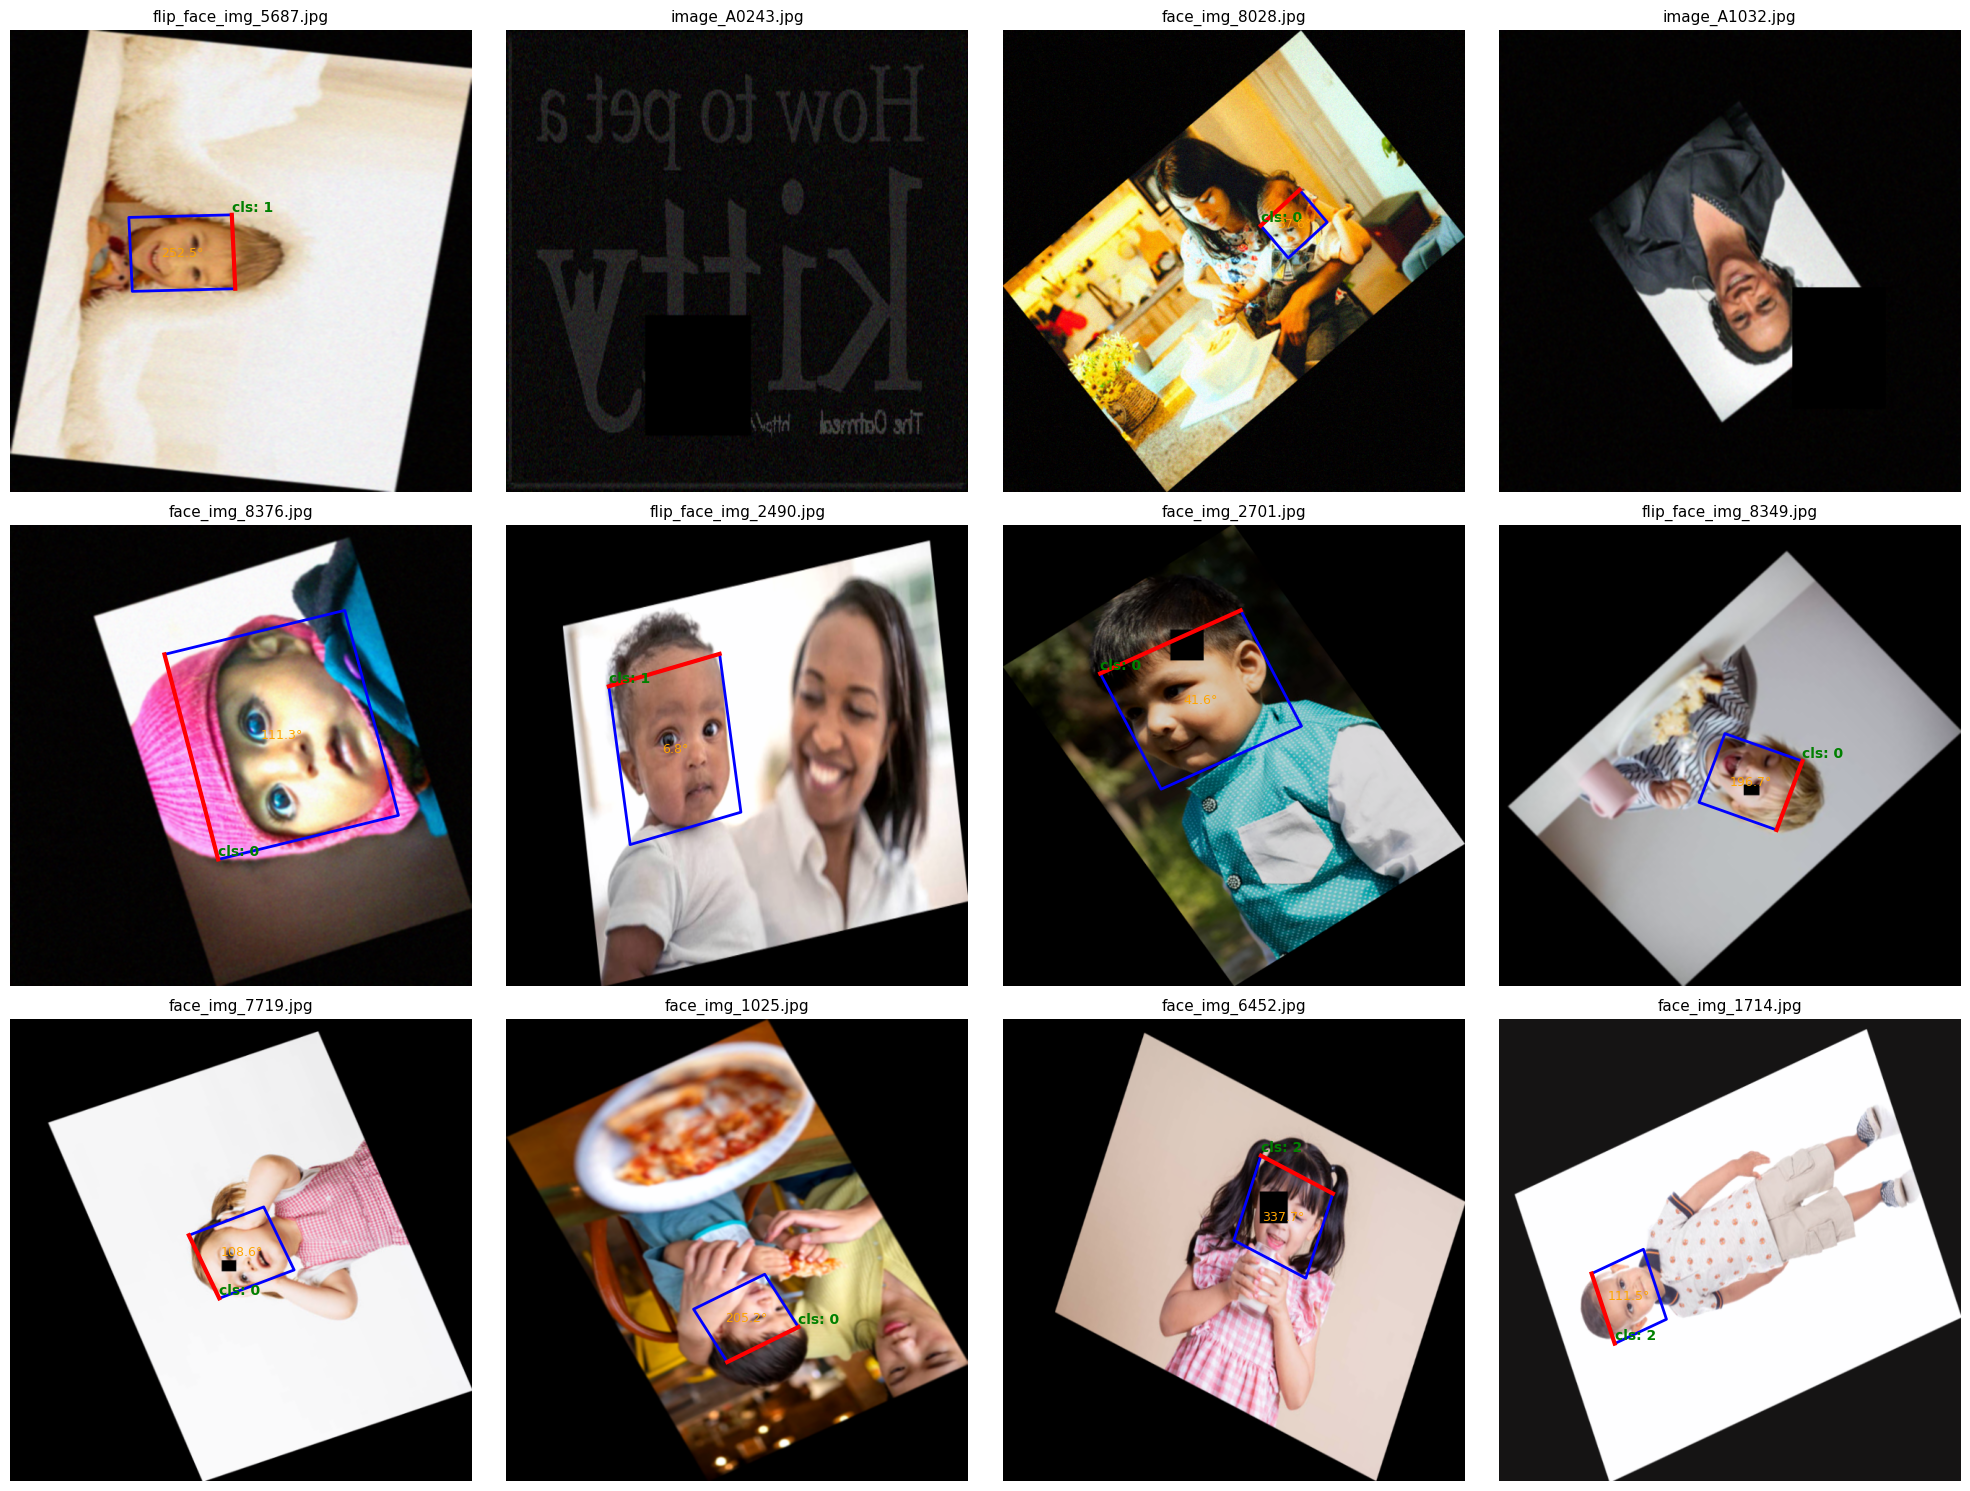

In [269]:
def denormalize_image(img_tensor, mean=(0.6427, 0.5918, 0.5526), std=(0.2812, 0.2825, 0.3036)):
    """
    Converts a normalized image tensor (C x H x W) back to a NumPy array (H x W x C) in uint8 format.
    
    Args:
        img_tensor (Tensor): The normalized image tensor.
        mean (tuple): Mean used during normalization (per channel).
        std (tuple): Std used during normalization (per channel).
    
    Returns:
        np.ndarray: Denormalized image in uint8 format.
    """
    img_np = img_tensor.cpu().numpy()
    for c in range(3):
        img_np[c] = img_np[c] * std[c] + mean[c]
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)
    return img_np.transpose(1, 2, 0)  # Convert to H x W x C


def draw_obb(ax, box, angle=None, class_idx=None, top_color='red', other_color='blue', linewidth=2):
    """
    Draws an oriented bounding box (OBB) and annotates it with class index and angle.

    Args:
        ax: Matplotlib axis.
        box: List or array of 8 values [x1, y1, ..., x4, y4].
        angle: Rotation angle in radians (optional).
        class_idx: Integer class index (optional).
    """
    pts = np.array(box).reshape(4, 2)
    pts_closed = np.vstack([pts, pts[0]])
    ax.plot(pts_closed[:, 0], pts_closed[:, 1], color=other_color, linewidth=linewidth)
    ax.plot([pts[0, 0], pts[1, 0]], [pts[0, 1], pts[1, 1]], color=top_color, linewidth=linewidth+1)

    # Class label near (x1, y1)
    if class_idx is not None:
        ax.text(pts[0, 0], pts[0, 1] - 5, f"cls: {class_idx}", color="green", fontsize=10, weight="bold")

    # Angle annotation at center of the box
    if angle is not None:
        center = pts.mean(axis=0)
        angle_deg = np.degrees(angle)
        ax.text(center[0], center[1], f"{angle_deg:.1f}°", color="orange", fontsize=9, ha="center", va="center")


def visualize_dataset(dataset, num_images=9):
    """
    Displays 'num_images' samples from the dataset in a grid.
    Shows OBBs with segment highlighting, class_idx, angle, and image filename.
    """
    total = len(dataset)
    if total == 0:
        print("Dataset is empty.")
        return

    indices = random.sample(range(total), min(num_images, total))
    cols = int(math.ceil(math.sqrt(len(indices))))
    rows = int(math.ceil(len(indices) / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = np.array(axes).reshape(-1)

    for ax in axes[len(indices):]:
        ax.axis("off")

    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample["image"]
        if torch.is_tensor(image):
            image_np = denormalize_image(image)
        else:
            image_np = image.copy()

        ax = axes[i]
        ax.imshow(image_np)
        ax.axis("off")

        boxes = sample["target"]["boxes"]
        angles = sample["target"]["angles"]
        class_idxs = sample["target"]["class_idxs"]

        if torch.is_tensor(boxes):
            boxes = boxes.cpu().numpy()
        if torch.is_tensor(angles):
            angles = angles.cpu().numpy()
        if torch.is_tensor(class_idxs):
            class_idxs = class_idxs.cpu().numpy()

        for j in range(len(boxes)):
            draw_obb(
                ax,
                box=boxes[j],
                angle=angles[j] if j < len(angles) else None,
                class_idx=class_idxs[j] if j < len(class_idxs) else None,
                top_color='red',
                other_color='blue',
                linewidth=2
            )

        # Add filename title
        base_name = dataset.file_list[idx]
        ax.set_title(f"{base_name}.jpg", fontsize=11, color="black")

    plt.tight_layout()
    plt.show()


# Ejemplo de uso:
# Supongamos que 'train_dataset' es una instancia de BabyFacesDataset ya creada.
visualize_dataset(train_dataset, num_images=12)



In [270]:
def conv_bn(inp, oup, stride = 1, leaky = 0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

def conv_bn_no_relu(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
    )

def conv_bn1X1(inp, oup, stride, leaky=0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

def conv_dw(inp, oup, stride, leaky=0.1):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),
    )

class SSH(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        assert out_channel % 4 == 0
        leaky = 0
        if (out_channel <= 64):
            leaky = 0.1
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel//2, stride=1)

        self.conv5X5_1 = conv_bn(in_channel, out_channel//4, stride=1, leaky = leaky)
        self.conv5X5_2 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

        self.conv7X7_2 = conv_bn(out_channel//4, out_channel//4, stride=1, leaky = leaky)
        self.conv7x7_3 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

    def forward(self, input):
        conv3X3 = self.conv3X3(input)

        conv5X5_1 = self.conv5X5_1(input)
        conv5X5 = self.conv5X5_2(conv5X5_1)

        conv7X7_2 = self.conv7X7_2(conv5X5_1)
        conv7X7 = self.conv7x7_3(conv7X7_2)

        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)
        out = F.relu(out)
        return out

class FPN(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FPN,self).__init__()
        leaky = 0
        if (out_channels <= 64):
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride = 1, leaky = leaky)
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride = 1, leaky = leaky)
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride = 1, leaky = leaky)

        self.merge1 = conv_bn(out_channels, out_channels, leaky = leaky)
        self.merge2 = conv_bn(out_channels, out_channels, leaky = leaky)

    def forward(self, input):
        # names = list(input.keys())
        input = list(input.values())

        output1 = self.output1(input[0])
        output2 = self.output2(input[1])
        output3 = self.output3(input[2])

        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")
        output2 = output2 + up3
        output2 = self.merge2(output2)

        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")
        output1 = output1 + up2
        output1 = self.merge1(output1)

        out = [output1, output2, output3]
        return out



class MobileNetV1(nn.Module):
    def __init__(self):
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.Sequential(
            conv_bn(3, 8, 2, leaky = 0.1),    # 3
            conv_dw(8, 16, 1),   # 7
            conv_dw(16, 32, 2),  # 11
            conv_dw(32, 32, 1),  # 19
            conv_dw(32, 64, 2),  # 27
            conv_dw(64, 64, 1),  # 43
        )
        self.stage2 = nn.Sequential(
            conv_dw(64, 128, 2),  # 43 + 16 = 59
            conv_dw(128, 128, 1), # 59 + 32 = 91
            conv_dw(128, 128, 1), # 91 + 32 = 123
            conv_dw(128, 128, 1), # 123 + 32 = 155
            conv_dw(128, 128, 1), # 155 + 32 = 187
            conv_dw(128, 128, 1), # 187 + 32 = 219
        )
        self.stage3 = nn.Sequential(
            conv_dw(128, 256, 2), # 219 +3 2 = 241
            conv_dw(256, 256, 1), # 241 + 64 = 301
        )
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 1000)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avg(x)
        # x = self.model(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x



In [271]:
def get_default_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [272]:
device = get_default_device()
device

device(type='mps')

In [273]:
# 👶 Adapted RetinaFace with Custom Heads for Baby Face Detection

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter

# Custom heads
class OBBHead(nn.Module):
    def __init__(self, inchannels=64, num_anchors=2):
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * 8, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        out = out.permute(0, 2, 3, 1).contiguous()
        return out.view(out.shape[0], -1, 8)

class AngleHead(nn.Module):
    def __init__(self, inchannels=64, num_anchors=2):
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * 1, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        out = out.permute(0, 2, 3, 1).contiguous()
        return out.view(out.shape[0], -1, 1)

class ClassHead(nn.Module):
    def __init__(self, inchannels=64, num_classes=6, num_anchors=2):
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * num_classes, kernel_size=1)
        self.num_classes = num_classes

    def forward(self, x):
        out = self.conv(x)
        out = out.permute(0, 2, 3, 1).contiguous()
        return out.view(out.shape[0], -1, self.num_classes)

# Final RetinaBabyFace model
class RetinaBabyFace(nn.Module):
    def __init__(self, backbone, return_layers, in_channel, out_channel, pretrain_path=None):
        """
        RetinaBabyFace Model with MobileNetV1 backbone and three heads:
        - Perspective classification
        - OBB regression
        - Angle prediction
        """
        super().__init__()

        # Load pretrained weights BEFORE IntermediateLayerGetter
        if pretrain_path:
            checkpoint = torch.load(pretrain_path, map_location='cpu')
            state_dict = checkpoint.get('state_dict', checkpoint)

            # Extraer solo los pesos del backbone (filtramos "body.stage")
            filtered_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('body.'):
                    k_clean = k.replace('body.', '')  # removemos el prefijo 'body.'
                    filtered_state_dict[k_clean] = v

            backbone.load_state_dict(filtered_state_dict, strict=False)

        # Backbone feature extractor
        self.body = IntermediateLayerGetter(backbone, return_layers)

        # FPN + SSH
        in_channels_list = [64, 128, 256]
        self.fpn = FPN(in_channels_list, out_channel)
        self.ssh1 = SSH(out_channel, out_channel)
        self.ssh2 = SSH(out_channel, out_channel)
        self.ssh3 = SSH(out_channel, out_channel)

        # Heads
        self.obb_head = nn.ModuleList([OBBHead(out_channel) for _ in range(3)])
        self.angle_head = nn.ModuleList([AngleHead(out_channel) for _ in range(3)])
        self.class_head = nn.ModuleList([ClassHead(out_channel, num_classes=6) for _ in range(3)])

    def forward(self, x):
        out = self.body(x)  # OrderedDict: {'0': feat1, '1': feat2, '2': feat3}
        fpn_outs = self.fpn(out)
        features = [self.ssh1(fpn_outs[0]), self.ssh2(fpn_outs[1]), self.ssh3(fpn_outs[2])]

        obbs = torch.cat([self.obb_head[i](f) for i, f in enumerate(features)], dim=1)
        angles = torch.cat([self.angle_head[i](f) for i, f in enumerate(features)], dim=1)
        persp_logits = torch.cat([self.class_head[i](f) for i, f in enumerate(features)], dim=1)

        return persp_logits, obbs, angles




In [ ]:
seed = set_seed(42)
backbone = MobileNetV1()
return_layers = {"stage1": "0", "stage2": "1", "stage3": "2"}  # ajustar según tu modelo
model = RetinaBabyFace(
    backbone=backbone,
    return_layers=return_layers,
    in_channel=64,           # según tu MobileNet
    out_channel=64,
    pretrain_path="/Users/jocareher/Downloads/mobilenet0.25_Final.pth"
).to(get_default_device())

In [275]:
model

RetinaBabyFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(1

In [276]:
device = get_default_device()
model.to(device)
model.eval()

dummy_input = torch.randn(2, 3, 640, 640).to(device)
with torch.no_grad():
    persp_logits, obbs, angles = model(dummy_input)
    print(persp_logits.shape, obbs.shape, angles.shape)

torch.Size([2, 16800, 6]) torch.Size([2, 16800, 8]) torch.Size([2, 16800, 1])


In [277]:
class RotationLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_angles, gt_angles, valid_mask=None):
        # Ambos tensores de forma (B, N, 1)
        loss = 1 - torch.cos(pred_angles.squeeze(-1) - gt_angles.squeeze(-1))
        if valid_mask is not None:
            loss = loss[valid_mask]
        return loss.mean()

class VertexLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_obbs, gt_obbs, valid_mask=None):
        # Entrada de forma (B, N, 8) → reshaped a (B*N, 4, 2)
        pred_vertices = pred_obbs[:, :, :8].reshape(-1, 4, 2)
        gt_vertices = gt_obbs[:, :, :8].reshape(-1, 4, 2)
        loss = F.smooth_l1_loss(pred_vertices, gt_vertices, reduction='none').mean(dim=[1,2])
        if valid_mask is not None:
            loss = loss[valid_mask.view(-1)]
        return loss.mean()

class MultiTaskLoss(nn.Module):
    def __init__(self, lambda_persp=1.0, lambda_vertex=1.0, lambda_rot=1.0):
        super().__init__()
        self.persp_loss_fn = nn.CrossEntropyLoss()
        self.vertex_loss_fn = VertexLoss()
        self.rotation_loss_fn = RotationLoss()
        self.lambda_persp = lambda_persp
        self.lambda_vertex = lambda_vertex
        self.lambda_rot = lambda_rot

    def forward(self, pred, targets):
        persp_logits, obbs, angles = pred
        persp_labels = targets['class_idx'].to(persp_logits.device)  # (B, N)
        obb_targets = targets['boxes'].to(obbs.device)                # (B, N, 8)
        angle_targets = targets['angle'].unsqueeze(-1).to(angles.device)  # (B, N, 1)
        valid_mask = targets.get('valid_mask', torch.ones_like(persp_labels, dtype=torch.bool)).to(persp_logits.device)

        # Flatten valid entries for perspective classification
        valid_flat = valid_mask.view(-1)
        loss_persp = self.persp_loss_fn(
            persp_logits.view(-1, 6)[valid_flat],
            persp_labels.view(-1)[valid_flat]
        )

        # Vertex and angle loss
        loss_vertex = self.vertex_loss_fn(obbs, obb_targets, valid_mask)
        loss_rot = self.rotation_loss_fn(angles, angle_targets, valid_mask)

        total_loss = (
            self.lambda_persp * loss_persp +
            self.lambda_vertex * loss_vertex +
            self.lambda_rot * loss_rot
        )
        return total_loss, loss_persp.item(), loss_vertex.item(), loss_rot.item()



In [278]:
class EarlyStopping:
    """
    EarlyStopping can be used to monitor the validation loss during training and stop the training process early
    if the validation loss does not improve after a certain number of epochs. It can handle both KFold and 
    non-KFold cases.
    """

    def __init__(
        self,
        patience: int = 7,
        verbose: bool = False,
        delta: float = 0,
        path: str = "checkpoint.pt",
        use_kfold: bool = False,
        trace_func=print,
    ):
        """
        Initializes the EarlyStopping object with the given parameters.

        Args:
            patience: How long to wait after last time validation loss improved.
            verbose: If True, prints a message for each validation loss improvement.
            delta: Minimum change in the monitored quantity to qualify as an improvement.
            path: Path for the checkpoint to be saved to.
            use_kfold: If True, saves the model with the lowest loss metric for each fold.
            trace_func: trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.use_kfold = use_kfold
        self.trace_func = trace_func
        self.fold = None
        self.filename = None

    def __call__(self, val_loss: float, model: nn.Module, fold: int = None):
        """
        This method is called during the training process to monitor the validation loss and decide whether to stop
        the training process early or not.

        Args:
            val_loss: Validation loss of the model at the current epoch.
            model: The PyTorch model being trained.
            fold: The current fold of the KFold cross-validation. Required if use_kfold is True.
        """
        if self.use_kfold:
            assert fold is not None, "Fold must be provided when use_kfold is True"

            # If it's a new fold, resets the early stopping object and sets the filename to save the model
            if fold != self.fold:
                self.fold = fold
                self.counter = 0
                self.best_score = None
                self.early_stop = False
                self.val_loss_min = np.Inf
                self.filename = self.path.replace(".pt", f"_fold_{fold}.pt")

        # Calculating the score by negating the validation loss
        score = -val_loss

        # If the best score is None, sets it to the current score and saves the checkpoint
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        # If the score is less than the best score plus delta, increments the counter
        # and checks if the patience has been reached
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True

        # If the score is better than the best score plus delta, saves the checkpoint and resets the counter
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: nn.Module):
        """
        Saves the model when validation loss decreases.

        Args:
            val_loss: The current validation loss.
            model: The PyTorch model being trained.
        """
        # If verbose mode is on, print a message about the validation loss decreasing and saving the model
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ..."
            )

        # Save the state of the model to the appropriate filename based on whether KFold is used or not
        if self.use_kfold:
            torch.save(model.state_dict(), self.filename)
        else:
            torch.save(model.state_dict(), self.path)

        # Update the minimum validation loss seen so far to the current validation loss
        self.val_loss_min = val_loss

In [ ]:
def create_optimizer(which_optimizer: str, model: nn.Module, learning_rate: float, weight_decay: float) -> torch.optim.Optimizer:
    if which_optimizer == "ADAM":
        return Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
    elif which_optimizer == "SGD":
        return SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError("El optimizador debe ser 'ADAM' o 'SGD'.")

def create_scheduler(which_scheduler: str, optimizer: torch.optim.Optimizer, learning_rate: float, epochs: int, train_dataloader) -> lr_scheduler._LRScheduler:
    if which_scheduler == "ReduceLR":
        return lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=5, min_lr=1e-5)
    elif which_scheduler == "Cosine":
        return lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    elif which_scheduler is None:
        return None
    else:
        raise ValueError("El scheduler debe ser 'ReduceLR', 'Cosine' o None.")

def build_multitask_targets(batch_targets, device):
    """
    Extrae los targets paddeados y los devuelve como tensores para el modelo multitarea.

    batch_targets: diccionario con claves:
        - boxes: (B, N, 8)
        - angles: (B, N)
        - class_idx: (B, N)
        - valid_mask: (B, N)
    """
    persp_labels = batch_targets["class_idx"].to(device)   # (B, N)
    obb_targets = batch_targets["boxes"].to(device)         # (B, N, 8)
    angle_targets = batch_targets["angles"].unsqueeze(-1).to(device)  # (B, N, 1)
    valid_mask = batch_targets["valid_mask"].to(device)     # (B, N)

    return {
        "class_idx": persp_labels,
        "boxes": obb_targets,
        "angle": angle_targets,
        "valid_mask": valid_mask
    }


def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               clip_value: float,
               grad_clip_mode: str,
               scheduler,  # Puede ser None o un scheduler
               device: torch.device) -> tuple:
    model.train()
    total_loss_sum = 0.0
    class_loss_sum = 0.0
    vertex_loss_sum = 0.0
    rotation_loss_sum = 0.0
    total_batches = 0

    for batch in train_dataloader:
        images = batch["image"].to(device)
        targets_raw = batch["target"]
        targets = build_multitask_targets(targets_raw, device)

        optimizer.zero_grad()
        pred = model(images)  # → (persp_logits, obbs, angles)
        loss, loss_persp, loss_vertex, loss_rot = loss_fn(pred, targets)
        loss.backward()

        if grad_clip_mode == "Norm":
            clip_grad_norm_(model.parameters(), clip_value)
        elif grad_clip_mode == "Value":
            clip_grad_value_(model.parameters(), clip_value)

        optimizer.step()

        if scheduler is not None and isinstance(scheduler, lr_scheduler.OneCycleLR):
            scheduler.step()

        total_loss_sum += loss.item()
        class_loss_sum += loss_persp
        vertex_loss_sum += loss_vertex
        rotation_loss_sum += loss_rot
        total_batches += 1

    current_lr = optimizer.param_groups[0]["lr"]
    avg_total_loss = total_loss_sum / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_vertex_loss = vertex_loss_sum / total_batches
    avg_rotation_loss = rotation_loss_sum / total_batches

    return avg_total_loss, avg_class_loss, avg_vertex_loss, avg_rotation_loss, current_lr


def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> tuple:
    model.eval()
    total_loss = 0.0
    class_loss_sum = 0.0
    vertex_loss_sum = 0.0
    rotation_loss_sum = 0.0
    total_batches = 0

    with torch.inference_mode():
        for batch in test_dataloader:
            images = batch["image"].to(device)
            targets_raw = batch["target"]
            targets = build_multitask_targets(targets_raw, device)

            pred = model(images)
            loss, loss_persp, loss_vertex, loss_rot = loss_fn(pred, targets)

            total_loss += loss.item()
            class_loss_sum += loss_persp
            vertex_loss_sum += loss_vertex
            rotation_loss_sum += loss_rot
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_vertex_loss = vertex_loss_sum / total_batches
    avg_rotation_loss = rotation_loss_sum / total_batches

    return avg_loss, avg_class_loss, avg_vertex_loss, avg_rotation_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          which_optimizer: str,
          weight_decay: float,
          learning_rate: float,
          epochs: int,
          device: torch.device,
          early_stopping=None,
          which_scheduler: str = None,
          clip_value: float = None,
          grad_clip_mode: str = None,
          record_metrics: bool = False,
          project: str = "My_WandB_Project",
          run_name: str = "My_Run") -> dict:

    results = {
        "train_total_loss": [],
        "train_persp_loss": [],
        "train_vertex_loss": [],
        "train_rotation_loss": [],
        "test_total_loss": [],
        "test_persp_loss": [],
        "test_vertex_loss": [],
        "test_rotation_loss": [],
    }

    model.to(device)
    optimizer = create_optimizer(which_optimizer=which_optimizer,
                                 model=model,
                                 learning_rate=learning_rate,
                                 weight_decay=weight_decay)

    scheduler = create_scheduler(which_scheduler=which_scheduler,
                                  optimizer=optimizer,
                                  learning_rate=learning_rate,
                                  epochs=epochs,
                                  train_dataloader=train_dataloader)

    if grad_clip_mode:
        assert grad_clip_mode in ["Norm", "Value"], "grad_clip_mode debe ser 'Norm' o 'Value'"

    start_time = time.time()
    if record_metrics:
        wandb.init(project=project, name=run_name)
        wandb.watch(model, loss_fn, log="all")

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        train_total_loss, train_persp_loss, train_vertex_loss, train_rotation_loss, current_lr = train_step(
            model=model,
            train_dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            clip_value=clip_value,
            grad_clip_mode=grad_clip_mode,
            scheduler=scheduler,
            device=device
        )

        # Para ReduceLROnPlateau
        if scheduler is not None and isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_total_loss)

        test_total_loss, test_persp_loss, test_vertex_loss, test_rotation_loss = test_step(
            model=model,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} | Train Loss: {train_total_loss:.4f} | Persp: {train_persp_loss:.4f} | Vertex: {train_vertex_loss:.4f} | Rot: {train_rotation_loss:.4f}")
        print(f"           |  Test Loss: {test_total_loss:.4f} | Persp: {test_persp_loss:.4f} | Vertex: {test_vertex_loss:.4f} | Rot: {test_rotation_loss:.4f} | LR: {current_lr:.6f} | Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s")

        if record_metrics:
            wandb.log({
                "epoch": epoch + 1,
                "train_total_loss": train_total_loss,
                "train_persp_loss": train_persp_loss,
                "train_vertex_loss": train_vertex_loss,
                "train_rotation_loss": train_rotation_loss,
                "test_total_loss": test_total_loss,
                "test_persp_loss": test_persp_loss,
                "test_vertex_loss": test_vertex_loss,
                "test_rotation_loss": test_rotation_loss,
                "learning_rate": current_lr,
                "epoch_time": epoch_time
            })

        results["train_total_loss"].append(train_total_loss)
        results["train_persp_loss"].append(train_persp_loss)
        results["train_vertex_loss"].append(train_vertex_loss)
        results["train_rotation_loss"].append(train_rotation_loss)
        results["test_total_loss"].append(test_total_loss)
        results["test_persp_loss"].append(test_persp_loss)
        results["test_vertex_loss"].append(test_vertex_loss)
        results["test_rotation_loss"].append(test_rotation_loss)

        if early_stopping is not None:
            early_stopping(test_total_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    elapsed_time = time.time() - start_time
    print(f"[INFO] Total training time: {elapsed_time//60:.0f} minutes, {elapsed_time%60:.2f} seconds")
    return results



In [ ]:
seed = set_seed(42)
 # Instanciar la pérdida multitarea con las nuevas funciones
multitask_loss = MultiTaskLoss(lambda_persp=1.0, lambda_vertex=1.0, lambda_rot=1.0)
earlystopping = EarlyStopping(patience=5, verbose=True, delta=0.001, path="checkpoint.pt", use_kfold=False)
# Entrenar
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=multitask_loss,
    which_optimizer="ADAM",
    weight_decay=1e-4,
    learning_rate=1e-4,
    epochs=50,
    device=device,
    early_stopping=earlystopping,
    which_scheduler=None,
    clip_value=None,              # Podés poner None si no querés clipping
    grad_clip_mode="Norm",       # O "Value" si preferís ese modo
    record_metrics=True,         # Activa logging en wandb
    project="RetinaBabyFace",
    run_name="run_1"
)

  0%|          | 0/50 [00:04<?, ?it/s]


IndexError: The shape of the mask [16] at index 0 does not match the shape of the indexed tensor [268800, 6] at index 0